CEL-Seq2: sensitive highly-multiplexed single-cell RNA-Seq.

*Hashimshony et al. Genome biology, 2016*

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

from prosstt import count_model as cm

In [2]:
from negbin_val_functions import *

prepare data according to the paper (see Methods)

In [3]:
cs1_man = pd.read_csv("/home/npapado/Documents/data/celseq2/GSE78779_CS1_manual.txt",
                   sep = "\t")
cs2_man = pd.read_csv("/home/npapado/Documents/data/celseq2/GSE78779_CS2_manual.txt",
                   sep = "\t")
cs2_c1 = pd.read_csv("/home/npapado/Documents/data/celseq2/GSE78779_Expression_C1_96_cells.txt",
                   sep = "\t")

# remove misc. from the end of the manuals
print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

tails = ["no_feature", "ambiguous", "too_low_aQual", "not_aligned", "alignment_not_unique"]
cs1m_spikes = [i for i, col in enumerate(cs1_man["#Sample:"]) if col in tails]
# print(cs1_man)
# print(cs1m_spikes)
cs1_man = cs1_man.drop(cs1m_spikes, 0)
cs2m_spikes = [i for i, col in enumerate(cs2_man["#Sample:"]) if col in tails]
cs2_man = cs2_man.drop(cs2m_spikes, 0)

print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

# remove spike-ins
print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

cs1m_spikes = [i for i, col in enumerate(cs1_man["#Sample:"]) if 'ERCC' in col]

cs1_man = cs1_man.drop(cs1m_spikes, 0)
cs2m_spikes = [i for i, col in enumerate(cs2_man["#Sample:"]) if 'ERCC' in col]
cs2_man = cs2_man.drop(cs2m_spikes, 0)
cs2c_spikes = [i for i, col in enumerate(cs2_c1["#Sample:"]) if 'ERCC' in col]
cs2_c1 = cs2_c1.drop(cs2c_spikes, 0)

print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

# remove the cells we don't need and the row that tells us what to keep
print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

keep = [0]
keep.extend(list(cs2_c1.iloc[0])[1:])
# print(np.sum(keep))
keep = np.array(keep, dtype=bool)

delete = np.logical_not(keep)
delete = cs2_c1.columns.values[delete]

# print(delete.shape)
cs2_c1 = cs2_c1.drop(delete, 1)
# print(test.shape)
cs2_c1 = cs2_c1.drop(0, 0)

print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

cs1_man = cs1_man.drop("#Sample:", 1)
cs2_man = cs2_man.drop("#Sample:", 1)
# cs2_c1 = cs2_c1.drop("#Sample:", 1)

(22818, 25) (22818, 21) (22814, 97)
(22813, 25) (22813, 21) (22814, 97)
(22813, 25) (22813, 21) (22814, 97)
(22721, 25) (22721, 21) (22722, 97)
(22721, 25) (22721, 21) (22722, 97)
(22721, 25) (22721, 21) (22721, 70)


In [4]:
# now make numpy arrays and go from here
cs1_man = np.array(cs1_man)
cs1_man = cs1_man.T
cs2_man = np.array(cs2_man)
cs2_man = cs2_man.T
cs2_c1 = np.array(cs2_c1)
cs2_c1 = cs2_c1.T

print(cs1_man.shape, cs2_man.shape, cs2_c1.shape)

(24, 22721) (20, 22721) (70, 22721)


In [6]:
# initial conditions
X = cs2_man
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("celseq2/cs2_man_scalings.txt", scalings)
X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X, scalings)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X, scalings)
negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X, scalings)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, p_res, r_res, nb_success]

save_all("celseq2", "cs2_man", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:268: RuntimeWarning: divide by zero encountered in log
  s3 = r * np.log(1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: divide by zero encountered in true_divide
  dp = r / p - X / (1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: invalid value encountered in true_divide
  dp = r / p - X / (1 - p)


In [7]:
# initial conditions
X = cs2_c1
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("celseq2/cs2_c1_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X, scalings)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X, scalings)
negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X, scalings)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, p_res, r_res, nb_success]

save_all("celseq2", "cs2_c1", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:268: RuntimeWarning: divide by zero encountered in log
  s3 = r * np.log(1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: divide by zero encountered in true_divide
  dp = r / p - X / (1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: invalid value encountered in true_divide
  dp = r / p - X / (1 - p)


In [8]:
# initial conditions
X = cs1_man
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("celseq2/cs1_man_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X, scalings)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X, scalings)
negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X, scalings)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, p_res, r_res, nb_success]

save_all("celseq2", "cs1_man", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:268: RuntimeWarning: divide by zero encountered in log
  s3 = r * np.log(1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: divide by zero encountered in true_divide
  dp = r / p - X / (1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: invalid value encountered in true_divide
  dp = r / p - X / (1 - p)


1.0 0.5336399056664026


/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


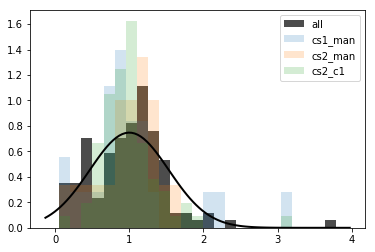

In [9]:
# scaling factors
fig, ax = plt.subplots()
sum1 = np.sum(cs1_man, axis=1)
sum2 = np.sum(cs2_man, axis=1)
sum3 = np.sum(cs2_c1, axis=1)
sum_all = np.concatenate([sum1, sum2, sum3])

scalings = sum_all / np.mean(sum_all)
mu, std = sp.stats.norm.fit(scalings)

all_n, all_bins, all_patches = ax.hist(scalings, bins=25, normed=True, alpha=0.7, color='black', label="all")

# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = sp.stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
print(mu, std)

ax.hist(sum1/np.mean(sum1), bins=all_bins, normed=True, alpha=0.2, label="cs1_man")
np.savetxt("celseq2/cs1_man_scalings.txt", sum1/np.mean(sum1))
ax.hist(sum2/np.mean(sum2), bins=all_bins, normed=True, alpha=0.2, label="cs2_man")
np.savetxt("celseq2/cs2_man_scalings.txt", sum2/np.mean(sum2))
ax.hist(sum3/np.mean(sum3), bins=all_bins, normed=True, alpha=0.2, label="cs2_c1")
np.savetxt("celseq2/cs2_c1_scalings.txt", sum3/np.mean(sum3))
ax.legend()

In [10]:
X = cs2_c1
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("celseq2/cs2_c1_genes.txt", gene_means)

X = cs2_man
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("celseq2/cs2_man_genes.txt", gene_means)

X = cs1_man
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("celseq2/cs1_man_genes.txt", gene_means)